# UMAP 

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display
from scipy.spatial.distance import pdist, squareform

In [2]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore

### Setting constants

Setting project, input and output folders.

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")

In [4]:
LOAD_EXISTING = True # load existing embedding

# UMAP projection

### Choose dataset

In [32]:
#dftype='full'
dftype='reduced'
#dftype='balanced'

spec_df = pd.read_pickle(DF_DICT[dftype])
labels = spec_df.call_lable.values
spec_df.shape

(1148, 34)

### Choose feature

In [33]:
specs = spec_df.spectrograms.copy()

# normalize feature
specs = [calc_zscore(x) for x in specs] 

# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

(1148, 5320)

## Run UMAP

In [34]:
embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_3D_'+dftype+'_default_params.csv')
print(embedding_filename)
if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
    embedding = np.loadtxt(embedding_filename, delimiter=";")
    print("File already exists")
else:
    reducer = umap.UMAP(n_components=3, min_dist = 0, random_state=2204)
    embedding = reducer.fit_transform(data)
    np.savetxt(embedding_filename, embedding, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_balanced_default_params.csv
File already exists


In [35]:
embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_2D_'+dftype+'_default_params.csv')
print(embedding_filename)
if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
    embedding2D = np.loadtxt(embedding_filename, delimiter=";")
    print("File already exists")
else:
    reducer = umap.UMAP(n_components=2, min_dist = 0, random_state=2204)
    embedding2D = reducer.fit_transform(data)
    np.savetxt(embedding_filename, embedding, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_2D_balanced_default_params.csv
File already exists


## Visualization

In [20]:
pal="Set2"

### 2D Plots

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_2D_plot_reduced_nolegend.jpg


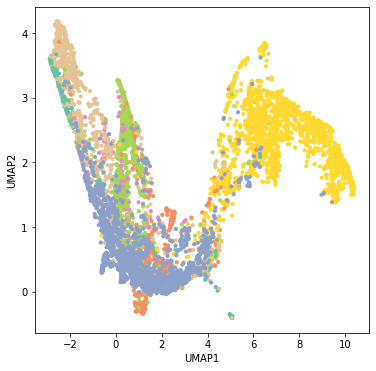

In [10]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_2D_plot_'+dftype+'_nolegend.jpg')
#outname=None
print(outname)
umap_2Dplot(embedding2D[:,0], embedding2D[:,1], labels, pal, outname=outname, showlegend=False)

### 3D Plot

#### Matplotlib 

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_3D_plot_reduced_nolegend.jpg


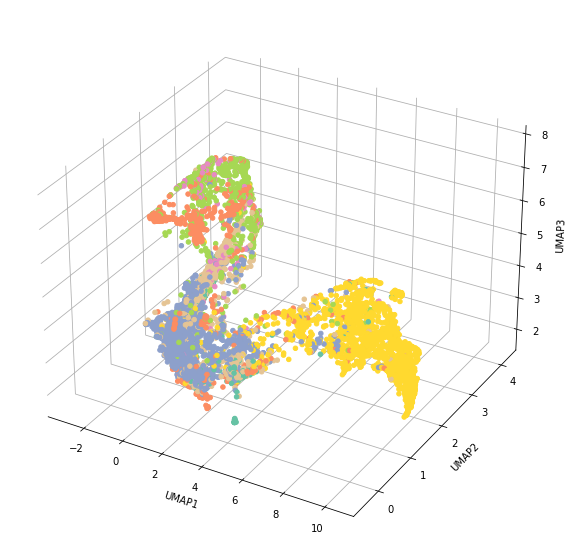

In [15]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_3D_plot_'+dftype+'_nolegend.jpg')
#outname=None
print(outname)

mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname,
            showlegend=False)

#### Plotly

In [13]:
#plotly_viz(embedding[:,0],
#           embedding[:,1],
#           embedding[:,2],
#           labels,
#           pal)

# Embedding evaluation

Evaluate the embedding based on calltype labels of nearest neighbors.

In [10]:
from evaluation_functions import nn, sil

In [17]:
nn_stats = nn(embedding, np.asarray(labels), k=5)

## Calculate metrics

In [18]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 61.80374532835941
Abs final metric (unweighted): 2.353601084423661


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_reduced.png


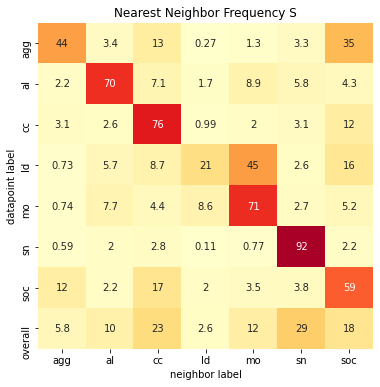

In [19]:
outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_reduced.png


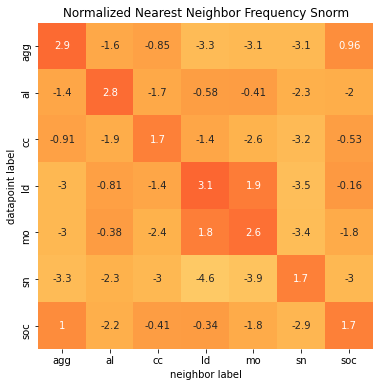

In [20]:
outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_Snorm(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatfold_UMAP_reduced.png


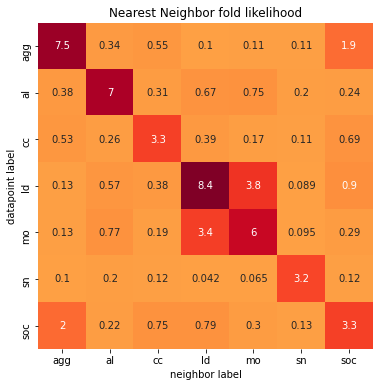

In [21]:
outname = os.path.join(os.path.sep, FIGURES, 'heatfold_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_fold(outname=outname)

# Within vs. outside distances

In [14]:
from evaluation_functions import plot_within_without

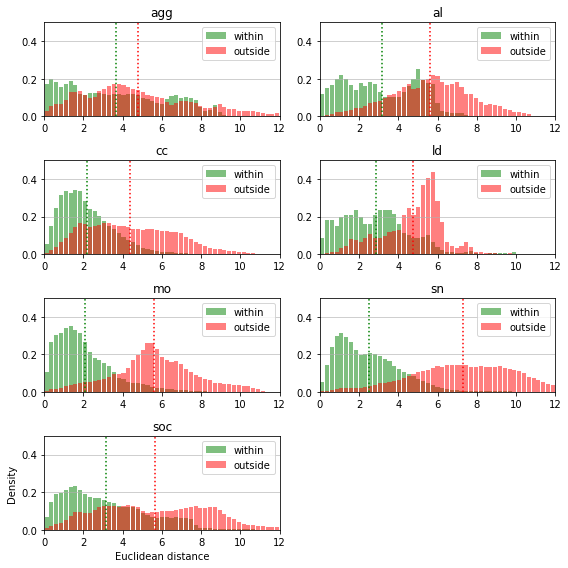

In [15]:
plot_within_without(embedding=embedding, labels=labels, outname="test.png")

## Silhouette Plot

In [36]:
sil_stats = sil(embedding, labels)

In [37]:
outname = os.path.join(os.path.sep, FIGURES, 'silplot_UMAP_'+dftype+'.png')
print(outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/silplot_UMAP_balanced.png


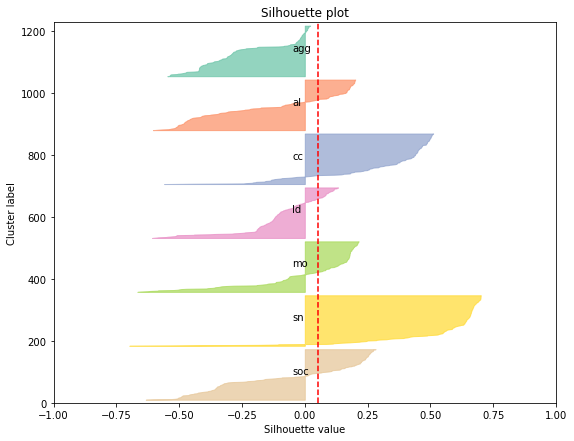

In [38]:
sil_stats.plot_sil(outname=outname)

## How many dimensions?

Evaluate, how many dimensions are best for the embedding.

In [26]:
specs = spec_df.spectrograms.copy()
# normalize feature
specs = [calc_zscore(x) for x in specs] 
# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

embeddings = {}
for n_dims in range(1,11):
    reducer = umap.UMAP(n_components = n_dims, min_dist = 0, metric='euclidean', random_state=2204)
    embeddings[n_dims] = reducer.fit_transform(data)    

In [27]:
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))
k=5
dims_tab = np.zeros((10,1))

for n_dims in range(1,11):
    nn_stats = nn(embeddings[n_dims], labels, k=k)
    stats_tab = nn_stats.get_statstab()
    mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    print(mean_metric)
    dims_tab[n_dims-1,:] = mean_metric

50.58424610415988
58.563857957885126
61.80374532835941
62.77403440295045
63.00331779923705
62.982056278621826
63.05904675978132
62.815992829918954
62.84994702911214
63.15648543919968


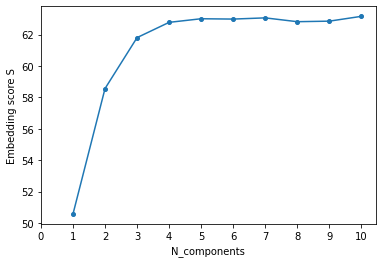

In [28]:
x = np.arange(1,11,1)
y = dims_tab[:,0]
plt.plot(x,y, marker='o', markersize=4)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.xticks(np.arange(0, 11, step=1))
plt.savefig(os.path.join(os.path.sep,FIGURES,'n_dims.png'), facecolor="white")

Note that this is different than doing UMAP with n=10 components and then selection only the first x dimensions in UMAP space!

# Graph from embedding evaluation

In [29]:
outname = os.path.join(os.path.sep,FIGURES,'simgraph_test.png')
nn_stats.draw_simgraph(outname)

Graph saved at  /home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/simgraph_test.png


Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

# Make interactive plot df

In [ ]:
embedding.head(3)

,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
0,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
2,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
embedding.columns = ['UMAP'+str(col) for col in embedding.columns]
embedding.columns

Index(['UMAP0', 'UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7',
       'UMAP8', 'UMAP9', 'UMAPindex_id'],
      dtype='object')

In [ ]:
for col in embedding.columns:
    spec_df[col] = embedding[col].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
plot_df = spec_df[['Name', 'call_lable', 'indv', 'raw_audio', 
                   'denoised_spectrograms','duration_s', 'samplerate_hz', 
                  'UMAP0', 'UMAP1', 'UMAP2', 'index_id', 'Sex', 'status', 'Start']]

In [ ]:
plot_df = plot_df.drop(columns=['denoised_spectrograms'])

In [ ]:
plot_df.head(3)

,Name,call_lable,indv,raw_audio,duration_s,samplerate_hz,UMAP0,UMAP1,UMAP2,index_id,Sex,status,Start,fn_1,fn_2,fn_3,HDBSCAN
1598,ALARM,al,HMB,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...",0.178,8000,5.299764,6.417554,4.202350,1598,M,Dominant,1:10:56.215,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1599,ALARM,al,HMB,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...",0.317,8000,6.663779,7.219666,3.152430,1599,M,Dominant,1:12:04.643,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1600,ALARM,al,HMB,"[0.005859375, 0.005859375, 0.0078125, 0.005859...",0.192,8000,6.665429,6.820063,4.278993,1600,M,Dominant,1:12:15.132,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,5


In [ ]:
plot_df.to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta')

In [ ]:
plot_df.iloc[:3000,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
plot_df.iloc[3000:,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

# Visualize example nearest neighbors

In [32]:
import random
import scipy
from sklearn.neighbors import NearestNeighbors

In [33]:
knn=5
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [34]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
names = spec_df.Name.values

In [37]:
# make plots per calltype

n_examples = 3

for calltype in calltypes:

    fig = plt.figure(figsize=(14,6))
    fig_name = 'NN_viz_'+calltype
    k=1
    call_indices = np.asarray(np.where(labels==calltype))[0]

    # randomly choose 3
    random.seed(2204)
    example_indices = random.sample(list(call_indices), n_examples)

    for i,ind in enumerate(example_indices):
        img_of_interest = spec_df.iloc[ind,:].spectrograms
        embedding_of_interest = embedding[ind,:]
        plt.subplot(n_examples, knn+1, k)
        #librosa.display.specshow(np.transpose(spec))
        plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
        #plt.title(calltype+' : 0')
        #plt.title(calltype)
        k=k+1

        nearest_neighbors = indices[ind]
        for neighbor in nearest_neighbors:
            neighbor_label = names[neighbor]
            neighbor_embedding = embedding[neighbor,:]
            dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
            neighbor_img = spec_df.iloc[neighbor,:].spectrograms
            plt.subplot(n_examples, knn+1, k)
            #librosa.display.specshow(np.transpose(spec))
            plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
            #plt.title(neighbor_label)
            #plt.title(neighbor_label+' : '+str(round(dist_to_original, 2)))
            k=k+1
        
    plt.tight_layout() 
    plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")
    plt.close()

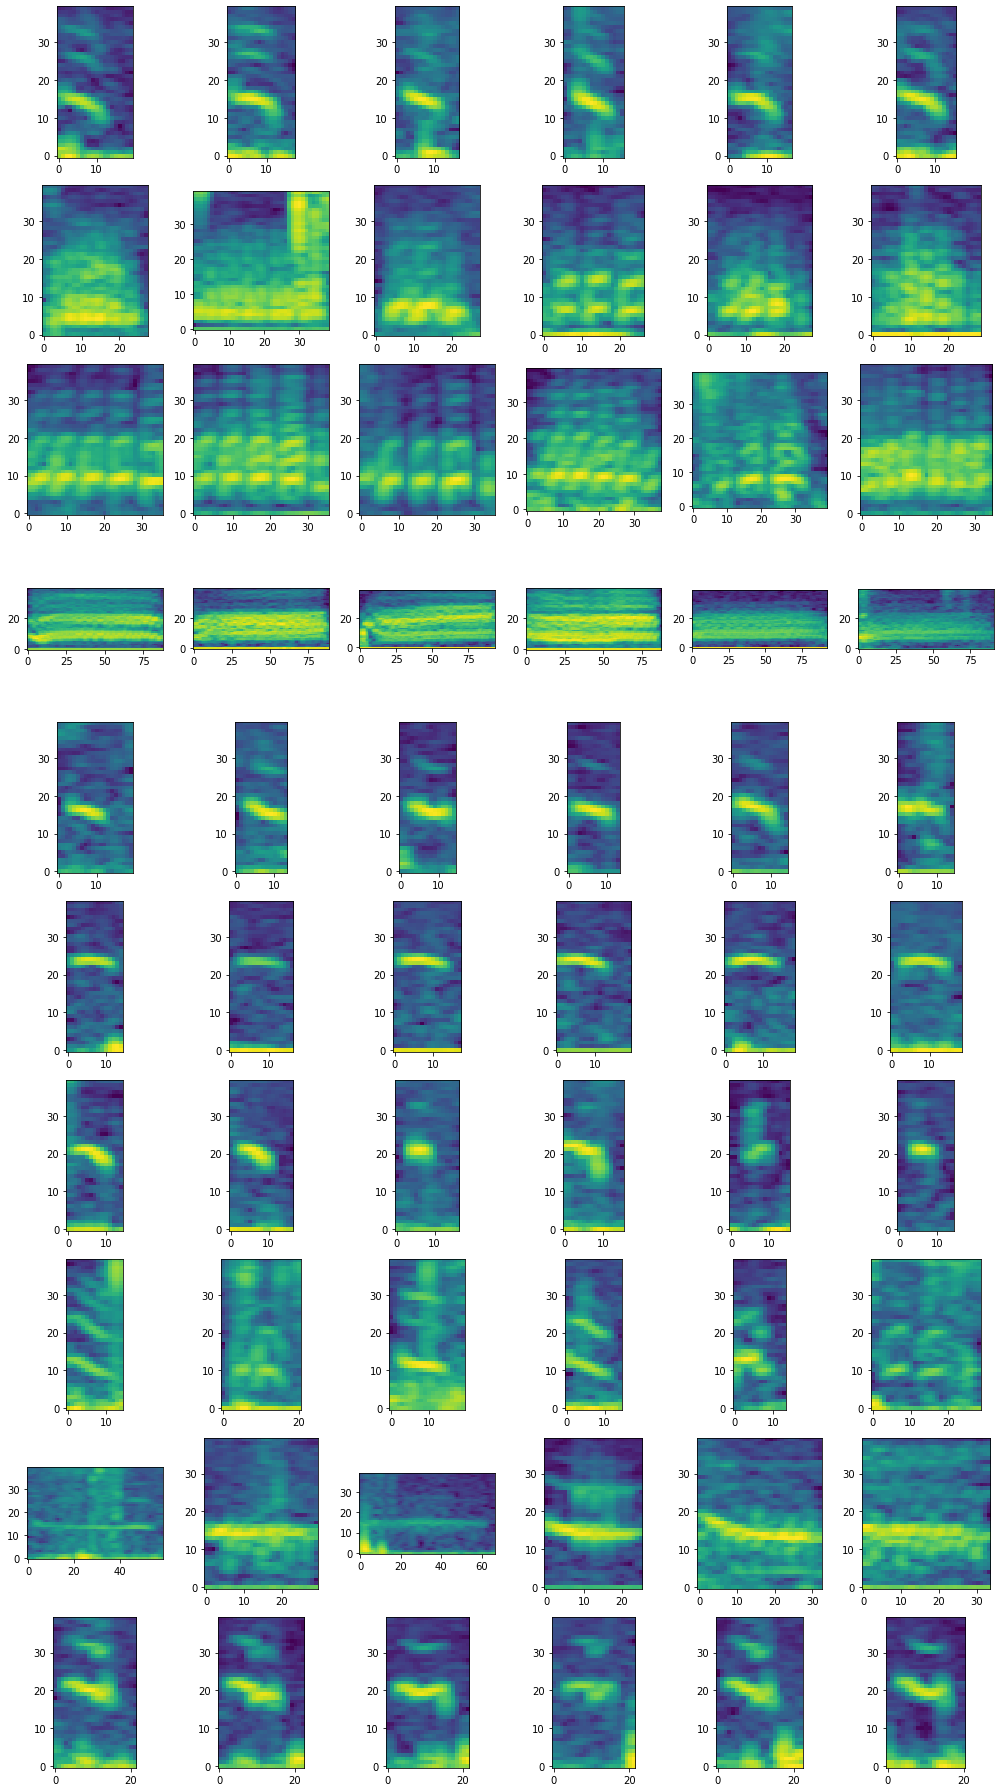

In [40]:
# general plot

n_examples = 10


fig = plt.figure(figsize=(14,25))
fig_name = 'NN_viz'
k=1

# randomly choose 3
random.seed(2204)
example_indices = random.sample(list(range(embedding.shape[0])), n_examples)

for i,ind in enumerate(example_indices):
    img_of_interest = spec_df.iloc[ind,:].spectrograms
    embedding_of_interest = embedding[ind,:]
    plt.subplot(n_examples, knn+1, k)
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
        neighbor_label = names[neighbor]
        neighbor_embedding = embedding[neighbor,:]
        dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
        neighbor_img = spec_df.iloc[neighbor,:].spectrograms
        plt.subplot(n_examples, knn+1, k)
        plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
        k=k+1
        
plt.tight_layout() 
plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")

# Files for Frants 2

In [ ]:
files = os.listdir(DATA+'frants/')

In [ ]:
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))

In [ ]:
files = os.listdir(DATA+'frants/')
fileIDs = [int(x.split('_')[0]) for x in files]

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
    # SOUNDFOCs are stereo
    if "SOUNDFOC" in wav_loc:
        data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
        data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
    else:
        data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

    if np.issubdtype(type(data[0]), np.integer):
        data = int16_to_float32(data)
    
    return data

In [ ]:
for fileID, filename in zip(fileIDs, files):
    sr = df.loc[df['index_id']==fileID,'samplerate_hz'].values[0]
    dur = df.loc[df['index_id']==fileID,'duration_s'].values[0]
    offset = df.loc[df['index_id']==fileID,'start_s'].values[0]
    wav_loc = df.loc[df['index_id']==fileID,'original_wav'].values[0]

    # add padding
    dur = dur+0.2
    offset = offset-0.1

    y = get_audio(wav_loc, offset, dur)
    librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, y, sr, norm=False)

In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id,Sex,status,filename
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...


# Visualize preprocessing steps

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/preprocessing_examples_mara.png


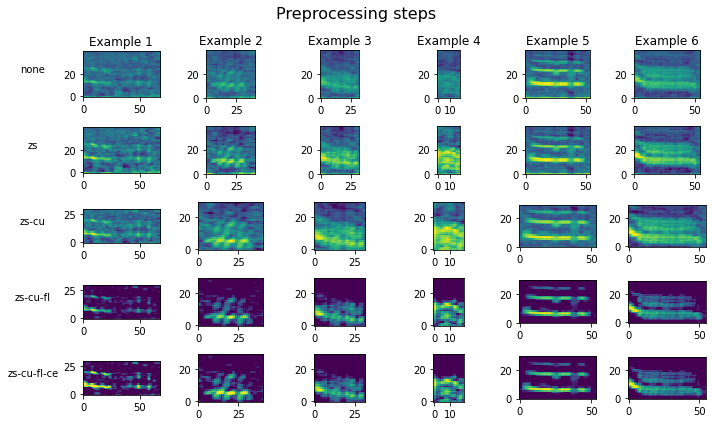

In [152]:
N_MELS = 40
MEL_BINS_REMOVED_UPPER = 5
MEL_BINS_REMOVED_LOWER = 5

# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(10,6))
fig_name = 'preprocessing_examples_mara.png'

fig.suptitle('Preprocessing steps', fontsize=16)
k=1

# randomly choose 4
examples = spec_df.sample(n=6, random_state=1)
examples.reset_index(inplace=True)
ori_specs = examples.denoised_spectrograms


# original

specs = ori_specs
vmin = np.min([np.min(x) for x in specs])
vmax = np.max([np.max(x) for x in specs])

for i in range(examples.shape[0]):
    spec = specs[i]
    plt.subplot(5, 6, k)
    #librosa.display.specshow(spec, y_axis='mel', fmin=0, fmax=4000)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal', norm=None,vmin=vmin, vmax=vmax)
    if i==0: plt.ylabel('none', rotation=0, labelpad=30)
    plt.title("Example "+str(i+1))
    k=k+1

# z-score
specs = ori_specs.copy()
#specs = [x[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:] for x in specs]
specs = [calc_zscore(s) for s in specs]
#vmin = np.min([np.min(x) for x in specs])
#vmax = np.max([np.max(x) for x in specs])
for i in range(examples.shape[0]):
    spec = specs[i]
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
    if i==0: plt.ylabel('zs', rotation=0, labelpad=30)
    k=k+1

# cut
for i in range(examples.shape[0]):
    spec = ori_specs[i]
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu', rotation=0, labelpad=30)
    k=k+1

# floor
for i in range(examples.shape[0]):
    spec = ori_specs[i]
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec < 0, 0, spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu-fl', rotation=0, labelpad=30)
    k=k+1

# ceiling
for i in range(examples.shape[0]):
    spec = ori_specs[i]

    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec < 0, 0, spec)
    spec = np.where(spec > 3, 3, spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu-fl-ce', rotation=0, labelpad=30)
    k=k+1

plt.tight_layout()
outname= os.path.join(os.path.sep,FIGURES,fig_name)
print(outname)
plt.savefig(outname)